##  Model Tiles

In this notebook, we will create  "Tiles" of satelitte  images with corresponding labels to be used in our model

In [1]:
import gdal
import osr
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
DG='/home/mcmccart/WIFIRE/Raw_Data/DigitalGlobe/'
LF='/home/mcmccart/WIFIRE/Raw_Data/LANDFIRE/'
Clip='/home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/'
Proj='/home/mcmccart/WIFIRE/Data_Prep_Work_Flow/ReProj_Files/'
Tile='/home/mcmccart/WIFIRE/Processed_Data/LabelledTiles_Veg_EqualArea/TIFF_Files/'

In [42]:
def ClipFile(SE,FileName,OutFile):
    #Input:
        # SE - Spatial Extent - [x1, y1, x2, y2]
        # Filename - name of file you wish to clip
    # OutFile - name of file you want to create
    gdal_str="/opt/anaconda3/bin/gdal_translate -projwin "+str.format('{0:.13f}', SE[0])+\
    " "+str.format('{0:.13f}', SE[1])+" "+str.format('{0:.13f}', SE[2])+\
    " "+str.format('{0:.13f}', SE[3])+" "+FileName+" "+OutFile
    os.system(gdal_str)
        
def GrabCornerCoordinates(FileName):
    src = gdal.Open(FileName)
    ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()
    lrx = ulx + (src.RasterXSize * xres)
    lry = uly + (src.RasterYSize * yres)
    return [ulx,uly,lrx,lry]
        
def IntersectBox(CC1,CC2):
    # Import:  Corner Coordinates in [Upper Left Long, Upper Left Lat, Lower Right Long, Lower Right Lat]
    # Note -- Assuming coordinates are in San Diego (aka - Long and + Lat)
    
    #Upper Left:
    ulx=max(CC1[0],CC2[0])
    uly=min(CC1[1],CC2[1])
    
    #Lower Right:
    lrx=min(CC1[2],CC2[2])
    lry=max(CC1[3],CC2[3])
    
    return [ulx,uly,lrx,lry]

def ToWGS84(FileName,OutName):
    gdal_str="/opt/anaconda3/bin/gdalwarp -t_srs wgs84 "+FileName +" "+OutName
    print(gdal_str)
    os.system(gdal_str)
    
def ToXYZ(FileName, OutName):
    gdal_str="/opt/anaconda3/bin/gdal_translate -of XYZ "+FileName +" "+OutName
    print(gdal_str)
    os.system(gdal_str)
    
def ImportXYZ(FileName,labelName):
    DF=pd.read_table(FileName, header=None)
    DF.columns=['Row']
    DF["Long"]=DF["Row"].apply(lambda x: float(x.split(" ")[0]))
    DF["Lat"]=DF["Row"].apply(lambda x: float(x.split(" ")[1]))
    DF[labelName]=DF["Row"].apply(lambda x: x.split(" ")[2])
    del DF["Row"]
    return DF

def Check_PlotExtentions(boxes,SE,plotname=None):
    #Input:
        #boxes -- dict of corner points (aka list of list), with [Upper Left Long, Upper Left Lat, Lower Right Long, Lower Right Lat]
    i=0
    color1=['-k','-b','-g','-m','-o','-c']
    plt.figure(figsize=(12,8))
    for k in boxes.keys():
        X=[boxes[k][0],boxes[k][2],boxes[k][2],boxes[k][0],boxes[k][0]]
        Y=[boxes[k][1],boxes[k][1],boxes[k][3],boxes[k][3],boxes[k][1]]
        plt.plot(X,Y,color1[i],label=k,linewidth=2.0)
        i+=1
    
    i=0
    color2=['--r','--y','--c','--o','--g']
    for k in SE:
        X=[SE[k][0],SE[k][2],SE[k][2],SE[k][0],SE[k][0]]
        Y=[SE[k][1],SE[k][1],SE[k][3],SE[k][3],SE[k][1]]
        plt.plot(X,Y,color2[i],label=k,linewidth=4.0) 
        i+=1
        
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if plotname!= None:
        plt.savefig(plotname+'.png')
        
def GetBorder(cx,cy,xres,yres):
    ulx=cx-0.5*xres
    uly=cy-0.5*yres
    lrx=ulx+xres
    lry=uly+yres
    return [ulx,uly,lrx,lry]

def GrabRes(FileName):
    src = gdal.Open(FileName)
    ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()
    return [xres,yres]

### Change Coordinate System

Satellite images are in WGS84, Vegetation maps are in NAD83.  Must reproject  Vegetation  onto WGS84

In [9]:
ToWGS84(LF+'sandiego-vegtype-2012.tif',Proj+'sandiego-vegtype-2012_ReProj.tif')

/opt/anaconda3/bin/gdalwarp -t_srs wgs84 /home/mcmccart/WIFIRE/Raw_Data/LANDFIRE/sandiego-vegtype-2012.tif /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/ReProj_Files/sandiego-vegtype-2012_ReProj.tif


In [11]:
ToWGS84(LF+'sandiego-vegtype-2014.tif',Proj+'sandiego-vegtype-2014_ReProj.tif')

/opt/anaconda3/bin/gdalwarp -t_srs wgs84 /home/mcmccart/WIFIRE/Raw_Data/LANDFIRE/sandiego-vegtype-2014.tif /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/ReProj_Files/sandiego-vegtype-2014_ReProj.tif


### Spatial Extent

Note  from previous analysis we know that  satellite  data  spatial extent is completely contained within  fuel/veg model  data spatial extent.  Thus we need  only satellite data to define our Escondido spatial extent

In [15]:
sat2014=GrabCornerCoordinates(DG+'Escondido2014.tif')
sat2012=GrabCornerCoordinates(DG+'Escondido2012v3.tif')
sat2010=GrabCornerCoordinates(DG+'escondido2010.tif')

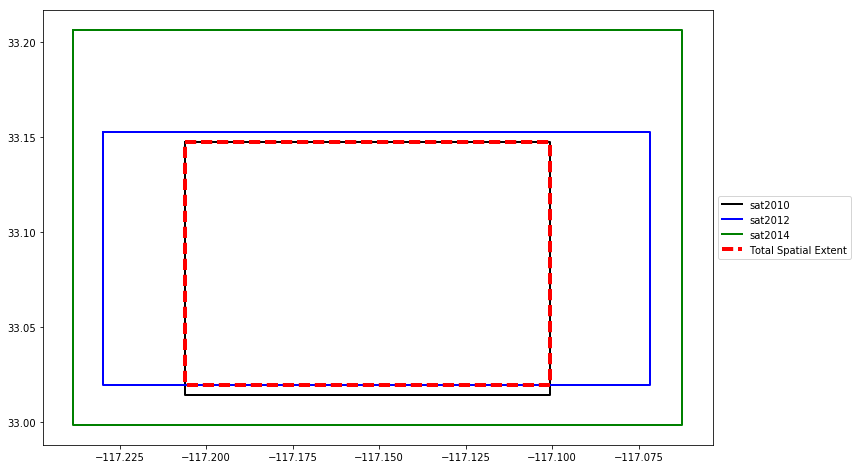

In [19]:
#Find Spatial Extent of LandFire & Sat data
s10_12=IntersectBox(sat2010,sat2012)
SE=IntersectBox(s10_12,sat2014)


data={'sat2010':sat2010,'sat2012': sat2012,'sat2014': sat2014}
intersect={'Total Spatial Extent':SE}
Check_PlotExtentions(data,intersect)

### Clip Files

Now lets get  vegetation and  satellite data for just the  defined spatial extent

In [20]:
SE

[-117.2060065897892,
 33.147178567916804,
 -117.10070755895937,
 33.01953127007837]

In [28]:
ClipFile(SE,DG+'Escondido2014.tif',Clip+'Clip_Sat2014_Escondido.tif')

In [29]:
ClipFile(SE,DG+'Escondido2012v3.tif',Clip+'Clip_Sat2012_Escondido.tif')

In [30]:
ClipFile(SE,DG+'escondido2010.tif',Clip+'Clip_Sat2010_Escondido.tif')

In [31]:
ClipFile(SE,Proj+'sandiego-vegtype-2012_ReProj.tif',Clip+'Clip_Veg2012_Escondido.tif')

In [32]:
ClipFile(SE,Proj+'sandiego-vegtype-2014_ReProj.tif',Clip+'Clip_Veg2014_Escondido.tif')

In [33]:
ClipFile(SE,Proj+'sandiego-vegtype-2010_ReProj.tif',Clip+'Clip_Veg2010_Escondido.tif')

### Make Tiles

We will create a Tile for every pixel in Vegetation.  To do this we  convert Veg  into XYZ files, which contain lat/long of center & label, then step through each pixel and create corrresponding satelitte tile

In [35]:
ToXYZ(Clip+'Clip_Veg2012_Escondido.tif', Clip+'Clip_Veg2012_Escondido.xyz')

/opt/anaconda3/bin/gdal_translate -of XYZ /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_Veg2012_Escondido.tif /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_Veg2012_Escondido.xyz


In [36]:
ToXYZ(Clip+'Clip_Veg2010_Escondido.tif', Clip+'Clip_Veg2010_Escondido.xyz')

/opt/anaconda3/bin/gdal_translate -of XYZ /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_Veg2010_Escondido.tif /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_Veg2010_Escondido.xyz


In [37]:
ToXYZ(Clip+'Clip_Veg2014_Escondido.tif', Clip+'Clip_Veg2014_Escondido.xyz')

/opt/anaconda3/bin/gdal_translate -of XYZ /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_Veg2014_Escondido.tif /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_Veg2014_Escondido.xyz


In [40]:
Veg2010=ImportXYZ(Clip+'Clip_Veg2010_Escondido.xyz','Veg')
Veg2012=ImportXYZ(Clip+'Clip_Veg2012_Escondido.xyz','Veg')
Veg2014=ImportXYZ(Clip+'Clip_Veg2014_Escondido.xyz','Veg')

In [43]:
Veg2010["VegIndex"]=Veg2010.index
Veg2012["VegIndex"]=Veg2012.index
Veg2014["VegIndex"]=Veg2014.index
Veg2010.head()

,Long,Lat,Veg,VegIndex
0,-117.205855,33.147027,3092,0
1,-117.205551,33.147027,3184,1
2,-117.205248,33.147027,3299,2
3,-117.204944,33.147027,3296,3
4,-117.204641,33.147027,3296,4


In [48]:
# Steps to making Tiles:
    #1. Find the spatial extent of each veg pixel
    #2. Clip the corresponding spatial extent from satelitte data

def CreateTiles(FileName,DF,label,SatFileName,TileFileName):
    [xres,yres]=GrabRes(FileName)
    poly=[]
    ULX=[]
    ULY=[]
    LRX=[]
    LRY=[]
    TileName=[]
    i=0
    for index, row in DF.iterrows():
        ulx,uly,lrx,lry=GetBorder(row["Long"],row["Lat"],xres,yres)
        ULX.append(ulx)
        ULY.append(uly)
        LRX.append(lrx)
        LRY.append(lry)
        tn=TileFileName+"_Idx"+str(row["VegIndex"])+"_"+str(row["Veg"])+".tif"
        TileName.append(tn)
        ClipFile([ulx,uly,lrx,lry],SatFileName,tn)
        if i%1000==0:
            print(i)
        i+=1
        
    DF_Tiles=pd.DataFrame({'Long':list(DF['Long'].values),'Lat':list(DF['Lat'].values),'Label':list(DF['Veg'].values),'VegFileIndex':list(DF['VegIndex'].values),"ulx":ULX,"uly":ULY,"lrx":LRX,"lry":LRY,'TileName':TileName})

    return DF_Tiles


In [ ]:
#Veg 2010
Veg2010_Tiles=CreateTiles(Clip+'Clip_Veg2010_Escondido.xyz',Veg2010,'Veg',Clip+'Clip_Sat2010_Escondido.tif',Tile+'VegTile_2010')


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000


In [ ]:
#Veg 2012
Veg2012_Tiles=CreateTiles(Clip+'Clip_Veg2012_Escondido.xyz',Veg2012,'Veg',Clip+'Clip_Sat2012_Escondido.tif',Tile+'VegTile_2012')


In [ ]:
#Veg 2014
Veg2014_Tiles=CreateTiles(Clip+'Clip_Veg2014_Escondido.xyz',Veg2014,'Veg',Clip+'Clip_Sat2014_Escondido.tif',Tile+'VegTile_2014')


In [ ]:
Ref=pd.concat([Veg2010_Tiles,Veg2012_Tiles,Veg2014_Tiles])
Ref.to_csv('/home/mcmccart/WIFIRE/Processed_Data/LabelledTiles_Veg_EqualArea/Reference_Veg_EqualArea.csv')